# Analyse channel 1 - 4
here I will analyse and process channel 1 - 4 of Alsdorf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference

plot_save=False #True False


# TO DO
# andere kalibrationsmethoden offenes ende --> Literatur lesen
# knick in dämpfung noch bearbeiten
# Vergleich mit anderen Kanälen systematisch machen

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
#%%time
# Wall time: 1min 56s

# # Load csv data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

In [3]:
#%%time
# Wall time: 7.64 s

# Load pickle Data
path_to_my_database_pickle = path_to_my_database + r"\pickle"
data_2021=import_my_database_pickle(2021, path_to_my_database_pickle)
data_2020=import_my_database_pickle(2020, path_to_my_database_pickle)
data_2019=import_my_database_pickle(2019, path_to_my_database_pickle)

In [4]:
#%%time
#Wall time: 61 s
data_all = merge_data_year([data_2019, data_2020, data_2021])
for chan in ["1","2","3","4"]:
    data_all[chan] = round(data_all[chan],2)
# empty the variables, not sure if this is really needed
data_2019=0
data_2020=0
data_2021=0

In [5]:
# def find_nearest_date(base_date_name,date_index):
#     """find the nearest date to base_date_name in date_index
#     base_date_name: put in as str or Timestamp, I use a format like this: '2021-06-07 18:52:45'
#     date_index: index of a dataframe, which contains dates
#     returns:
#     date_name: str
#     date_iloc: position of date_name in date_index
#     """
#     date_iloc=date_index.get_loc(base_date_name,method="nearest")
#     date_name=str(date_index[date_iloc])
#     return date_name, date_iloc



In [6]:
# Load data T-logger
#path_to_data_Tlogger = r"..\Alsdorf\Daten\T-logger"
path_to_my_database = r"..\Alsdorf\Daten\my_database"
#df_Tlogger.to_csv(path_to_my_database + "/t_logger_watertank/Tlogger.csv")
df_Tlogger = read_pickle(path_to_my_database + "/t_logger_watertank/Tlogger")

watertank_T_range_min = df_Tlogger["Channel1-Watertank"].index.min()
watertank_T_range_max = df_Tlogger["Channel1-Watertank"].index.max()

df_Tlogger

,Channel1-Watertank,Channel2-Air,Channel1-rolling_mean
2021-06-07 12:12:40,24.948476,25.819904,24.954713
2021-06-07 12:13:40,25.026853,25.443956,24.968877
2021-06-07 12:14:40,24.888809,25.165027,24.978021
2021-06-07 12:15:40,25.011371,24.926351,24.980537
2021-06-07 12:16:40,25.014596,24.753213,24.954153
...,...,...,...
2021-07-27 09:24:23,23.543907,NaN,23.585051
2021-07-27 09:27:24,23.621052,NaN,23.583765
2021-07-27 09:30:24,23.576051,NaN,23.574765
2021-07-27 09:33:24,23.588908,NaN,23.582479


In [7]:
# # copied from analyse_my_database_alsdorf.ipynb
# def temp_watertank_func(x):
#     """returns Temperature of Watertank at given time x, of the moving avearage values
#     this is not really a matheamtical function, but I named it like this when I was using a polynomial function
#     """
#     # find nearest date in moving avearge
#     temp = []
#     for date in x:
#         date_name, date_iloc = find_nearest_date(date,df_Tlogger["Channel1-rolling_mean"].index)
#         Temperature = df_Tlogger["Channel1-rolling_mean"][date_name]
#         Temperature_round = round(Temperature, 7) #round to 7s decimal place
#         temp.append(Temperature_round)
#     return temp

# Process Data
copied from other script and adjusted

additional processing of the data, e.g. delete outlier, align dataframes so that the dates fit

In [8]:
data_all_processed=deepcopy(data_all)

# delete egrt cable channels
for egrt_chan in ["5","6","7","8"]:
    del data_all_processed[egrt_chan]

# Cut dataframes so they only cover the time of the t-Logger
# find the date range of this channel, which also is covered by the T-Logger
date_iloc_min_list=[]
date_iloc_max_list=[]
for chan in ["1","2","3","4"]:
    date_name_min, date_iloc_min = find_nearest_date(watertank_T_range_min,data_all_processed[chan].index)
    date_name_max, date_iloc_max = find_nearest_date(watertank_T_range_max,data_all_processed[chan].index)
    #all_dates_in_range_channel   = data_all_processed[chan].index[date_iloc_min:date_iloc_max]
    date_iloc_max_list.append(date_iloc_max)
    date_iloc_min_list.append(date_iloc_min)
    #print(chan);print(date_iloc_min);print(date_iloc_max);print()
#range dates which has to be applied to all channels. Channels have been "alligned" regarding the date before. To keep this allignmend datepoints of all channels have to be dropped togehter. So the channel which has the newest first date in t-logger date range is important.[-->max(date_iloc_min_list)] And the channel which has the oldest last date in t-logger range is important. [-->min(date_iloc_max_list)]
date_iloc_max = min(date_iloc_max_list)
date_iloc_min = max(date_iloc_min_list)
# drop the dates which are not covered by t-logger
for chan in ["1","2","3","4"]:
    data_all_processed[chan] = data_all_processed[chan].drop(data_all_processed[chan].index[0:date_iloc_min],axis=0)
    new_max_index = date_iloc_max - date_iloc_min # I already dropped some values, therefore the index changed
    data_all_processed[chan] = data_all_processed[chan].drop(data_all_processed[chan].index[new_max_index:],axis=0)
check_first_last_date(data_all_processed, channels=["1","2","3","4"])


Channel: 1; Number of dates: 2342
first (oldes) date: 2021-06-07 12:12:22
last (newest) date: 2021-07-26 23:23:33

Channel: 2; Number of dates: 2342
first (oldes) date: 2021-06-07 15:28:30
last (newest) date: 2021-07-27 02:39:41

Channel: 3; Number of dates: 2342
first (oldes) date: 2021-06-07 17:08:35
last (newest) date: 2021-07-27 04:19:46

Channel: 4; Number of dates: 2342
first (oldes) date: 2021-06-07 19:20:40
last (newest) date: 2021-07-27 07:03:53


In [9]:
a=data_all_processed
###################### Correct date missmatch, must be done manually at the moment####################################
#print("--- Before removing date points ---")
#check_first_last_date(a,channels=["1","2","3","4"])
#print("--- --- --- --- --- --- --- --- --- ---")
# Warum gibt es diesen unterschied ??????
a["1"] = a["1"].drop(a["1"].index[0:13],axis=0)
a["2"] = a["2"].drop(a["2"].index[0:7],axis=0)
a["3"] = a["3"].drop(a["3"].index[0:4],axis=0)

a["2"] = a["2"].drop(a["2"].index[-6:],axis=0)
a["3"] = a["3"].drop(a["3"].index[-9:],axis=0)
a["4"] = a["4"].drop(a["4"].index[-14:],axis=0)

a["1"] = a["1"].drop(a["1"].index[2125],axis=0)
a["2"] = a["2"].drop(a["2"].index[2125],axis=0)
a["3"] = a["3"].drop(a["3"].index[2125],axis=0)
# Check if the changes are as expected
print("--- After removing some date points ---")
check_first_last_date(a,channels=["1","2","3","4"])
####################################################################################################################

--- After removing some date points ---

Channel: 1; Number of dates: 2328
first (oldes) date: 2021-06-07 19:08:40
last (newest) date: 2021-07-26 23:23:33

Channel: 2; Number of dates: 2328
first (oldes) date: 2021-06-07 19:12:40
last (newest) date: 2021-07-26 23:27:33

Channel: 3; Number of dates: 2328
first (oldes) date: 2021-06-07 19:16:40
last (newest) date: 2021-07-26 23:31:33

Channel: 4; Number of dates: 2328
first (oldes) date: 2021-06-07 19:20:40
last (newest) date: 2021-07-26 23:35:33


# Check processing steps

In [10]:
def check_processed_data(channels=["1","2","3","4"],my_Warning=False):
    """some checks for my processed data"""
    # check if all channels have the same number of date points (index length)
    n={}
    for chan in channels:
        n[chan]=len(data_all_processed[chan].index) # number of date points of this channel
    for chan in n:
        for other_chan in n: # it also counts the channel of the upper loop but thats not important
            n_dates_difference = n[chan] - n[other_chan]
            if n_dates_difference != 0:
                my_Warning = True
                print(f"Channel {chan} and Chanel {other_chan} have a different index length --> different number of dates")

    # check if the first measurement of channel 1 has the oldest measurement and the first of channel 8 the newest
    a=data_all_processed # for shortening code
    if a["1"].index[0] < a["2"].index[0] and a["2"].index[0] < a["3"].index[0] and a["3"].index[0] < a["4"].index[0]:
        #print("order of first dates is good")
        pass
    else:
        my_Warning = True
        print("!order of first dates is not good!")
    # check last dates
    if a["1"].index[-1] < a["2"].index[-1] and a["2"].index[-1] < a["3"].index[-1] and a["3"].index[-1] < a["4"].index[-1]:
        #print("order of last dates is good")
        pass
    else:
        my_Warning = True
        print("!order of last dates is not good!")

    # check all date differences
    allowed_diff_5_min={}
    allowed_diff_9_min={}
    allowed_diff_13_min={}
    allowed_diff_5_min["2 - 1"]  = a["2"].index - a["1"].index
    allowed_diff_5_min["3 - 2"]  = a["3"].index - a["2"].index
    allowed_diff_5_min["4 - 3"]  = a["4"].index - a["3"].index
    allowed_diff_9_min["4 - 2"]  = a["4"].index - a["2"].index
    allowed_diff_9_min["3 - 1"]  = a["3"].index - a["1"].index
    allowed_diff_13_min["4 - 1"] = a["4"].index - a["1"].index

    def print_timediff_warning():
        my_Warning = True
        print("timediff between to dates is not in expected range")
        print(f"in Channel {channelpair}: {timediff}")

    for channelpair in allowed_diff_5_min:
        for timediff in allowed_diff_5_min[channelpair]:
            if timediff > timedelta(minutes=5) or timediff < timedelta(minutes=4):
                print_timediff_warning()
        
    for channelpair in allowed_diff_9_min:
        for timediff in allowed_diff_9_min[channelpair]:
            if timediff > timedelta(minutes=10) or timediff < timedelta(minutes=8):
                print_timediff_warning()

    for timediff in allowed_diff_13_min["4 - 1"]: # has only one channelpair
        if timediff > timedelta(minutes=14) or timediff < timedelta(minutes=12):
            print_timediff_warning()

    return my_Warning

# Check my processed data
my_Warning = check_processed_data()
# Print Warning if one check was wrong
if my_Warning == True:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!Do the manual check again!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
else:
    print("All checks OK")
    print("Check timedifferences between channels: OK")
    print("Check first and last date: OK")
    print("Check number date measurements: OK")

All checks OK
Check timedifferences between channels: OK
Check first and last date: OK
Check number date measurements: OK


In [11]:
for chan in ["1","2","3","4"]:
    data_all[chan] = data_all[chan][::5] #only use every 5th row
    #data_all_processed[chan] = data_all_processed[chan][::5] #only use every 5th row

# Watertank shift

In [12]:
#%%time
#Wall time: 26.2 s
#25 1689 1723 3389
watertank_len=[71] # position DTS cable, where it is in watertank
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger, channels=["1","2","3","4"], watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Plot watertank correction

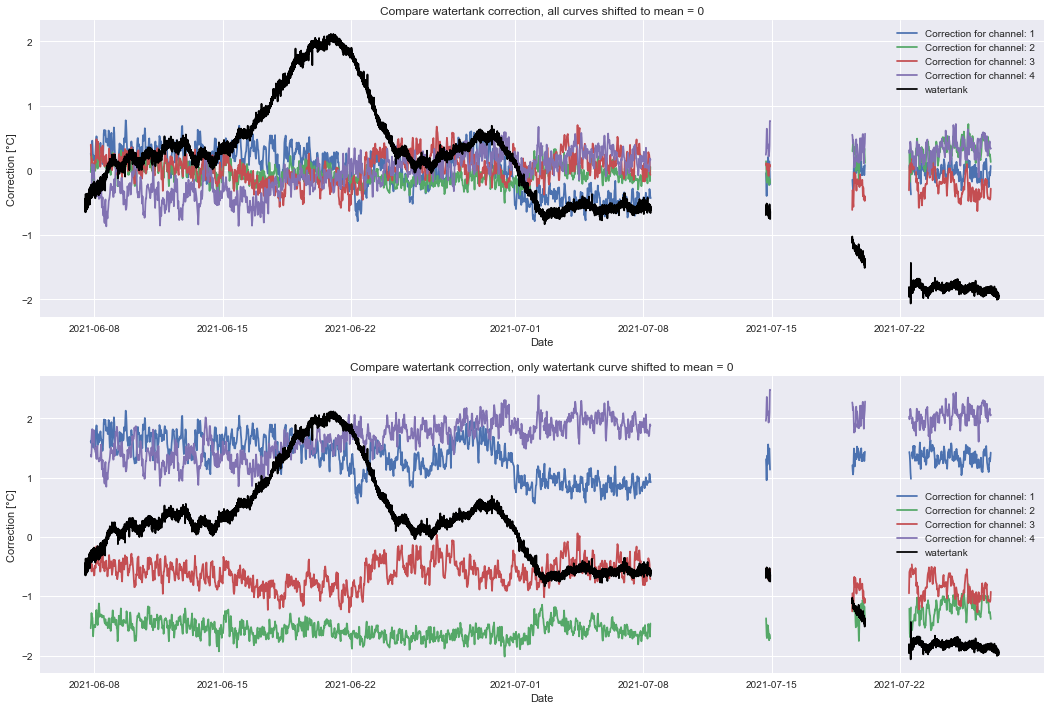

In [13]:
fig,axs=plt.subplots(2,1,figsize=(18,12))
for chan in watertank_diff_log_data_all.keys():
    # shift everything to mean = 0
    mean=np.nanmean(watertank_diff_log_data_all[chan].loc[watertank_len[0]])
    y=watertank_diff_log_data_all[chan].loc[watertank_len[0]] - mean

    axs[0].plot(watertank_diff_log_data_all[chan].columns,y,label=f"Correction for channel: {chan}")
# plot watertank Temp for comparisson
mean = np.nanmean(df_Tlogger["Channel1-Watertank"].values)
y=df_Tlogger["Channel1-Watertank"].values - mean
x_dates=df_Tlogger["Channel1-Watertank"].index
axs[0].plot(x_dates,y,color="black", label="watertank")

axs[0].set_title("Compare watertank correction, all curves shifted to mean = 0")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Correction [°C]")
axs[0].legend()

# Plot only shift watertank to mean 0
for chan in watertank_diff_log_data_all.keys():
    y=watertank_diff_log_data_all[chan].loc[watertank_len[0]]

    axs[1].plot(watertank_diff_log_data_all[chan].columns,y,label=f"Correction for channel: {chan}")
# plot watertank Temp for comparisson
mean = np.nanmean(df_Tlogger["Channel1-Watertank"].values)
y=df_Tlogger["Channel1-Watertank"].values - mean
x_dates=df_Tlogger["Channel1-Watertank"].index
axs[1].plot(x_dates,y,color="black", label="watertank")

axs[1].set_title("Compare watertank correction, only watertank curve shifted to mean = 0")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Correction [°C]")
axs[1].legend()

plt.show()

In [14]:
# save corrected data
write_pickle("./data_all_processed_shifted_ch1-4",data_all_processed_shifted) # I use this as comparisson in another skript

# Compare EGRT Cable channel 1 - 4 to Wireline T-Logger 2020

## Correct older data
assuming a constant offset to the watertank

In [15]:
# get mean watertank diff correction value to correct older data
mean_watertank_diff={}
for chan in ["1","2","3","4"]:
    mean_watertank_diff[chan] = watertank_diff_log_data_all[chan].loc[watertank_len[0]].mean()

# Correct all values with this shift
data_all_shifted={}
for chan in ["1","2","3","4"]:
    data_all_shifted[chan] = data_all[chan] - mean_watertank_diff[chan]

In [16]:
# Load Wireline data
path_to_wireline = r"..\Alsdorf\Daten\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

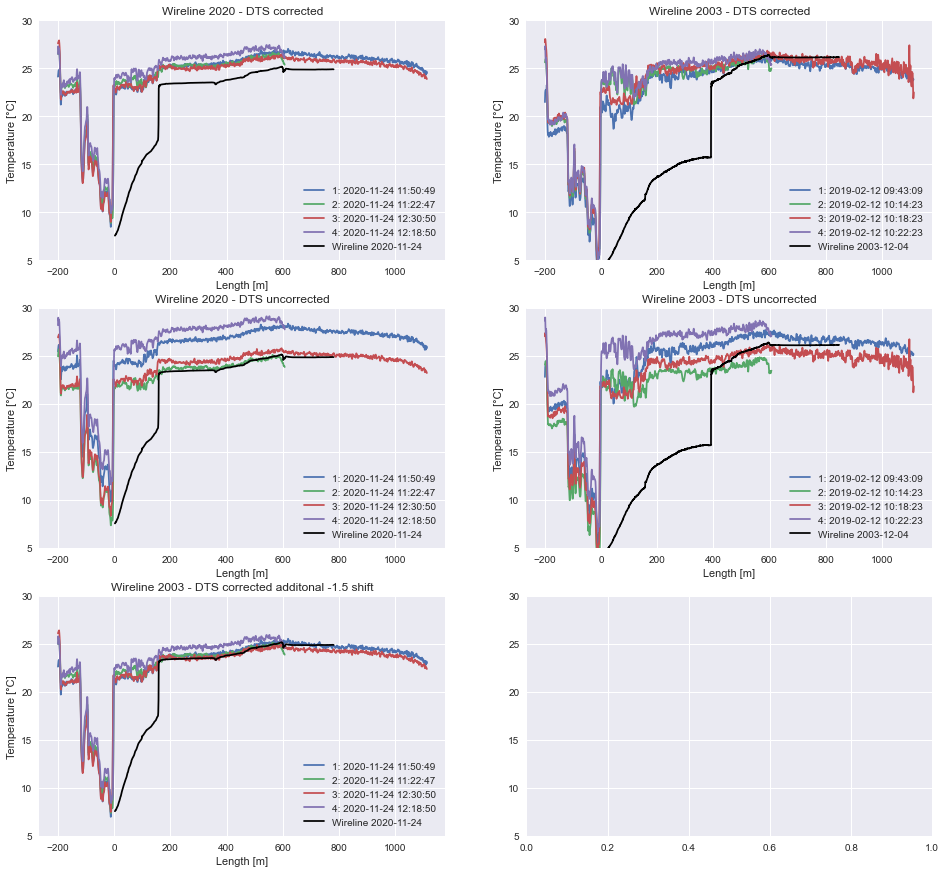

In [17]:
# Compare Wireline with Channel 1-4
offset=200 # muss ich noch genauer nachgucken
fig,axs=plt.subplots(3,2,figsize=[16,15])
axs[0,0].set_title("Wireline 2020 - DTS corrected")
axs[1,0].set_title("Wireline 2020 - DTS uncorrected")
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
    axs[0,0].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"{chan}: {date_name}")
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all[chan].index)
    axs[1,0].plot(data_all[chan].loc[date_name].index - offset,data_all[chan].loc[date_name].values,label=f"{chan}: {date_name}")
for ax in [axs[0,0],axs[1,0]]:
    ax.plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline 2020-11-24",color="black")
    ax.legend()
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")

axs[0,1].set_title("Wireline 2003 - DTS corrected")
axs[1,1].set_title("Wireline 2003 - DTS uncorrected")
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2003-12-04 12:00:00",data_all_shifted[chan].index)
    axs[0,1].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"{chan}: {date_name}")
    axs[1,1].plot(data_all[chan].loc[date_name].index - offset,data_all[chan].loc[date_name].values,label=f"{chan}: {date_name}")
for ax in [axs[0,1],axs[1,1]]:
    ax.plot(wireline_measurements2003["BHT"].index,wireline_measurements2003["BHT"].values,label="Wireline 2003-12-04",color="black")
    ax.legend()
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")

axs[2,0].set_title("Wireline 2003 - DTS corrected additonal -1.5 shift")
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
    axs[2,0].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values -1.5,label=f"{chan}: {date_name}")
for ax in [axs[2,0]]:
    ax.plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline 2020-11-24",color="black")
    ax.legend()
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")

for ax in [axs[0,0],axs[0,1],axs[1,0],axs[1,1],axs[2,0],axs[2,1]]:
    ax.set_ylim([5,30])

#plt.savefig("pictures/Ch1-4_wireline.png",dpi=720)

# andere Zeitpunkte von dem Tag passen auch nicht besser:
# for chan in ["1","2","3","4"]:
#     for hour in range(0,24,1):
#         date_name, date_iloc = find_nearest_date(f"2020-11-24 {hour}:00:00",data_all_shifted[chan].index)
#         plt.plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"{chan}: {date_name}")
#         #date_name, date_iloc = find_nearest_date(f"2020-11-24 {hour}:00:00",data_all[chan].index)
#         #plt.plot(data_all[chan].loc[date_name].index - offset,data_all[chan].loc[date_name].values,label=f"{chan}: {date_name}")
# plt.plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline 2020-11-24",color="black")
# plt.legend()

### Interpretation
* 2020 unterscheiden sich die Daten sehr. Ist die Kalibration der rückliegenden Daten unzureichend? Die Ähnlichkeit der Daten von 2003 und 2019 ist denke ich Zufall?
* die unkorrigierten Werte von Kanal 2 und 3 passen ungefähr zu den Werten vom T-Log. Zufall?

# Extract shaft
from processed data

In [18]:
begin_shaft=200 # muss ich noch genauer nachgucken
# muss auch noch genauer überprüft werden, dieser Wert beschreibt wie weit die Faser von Channel 1 und 3 geht, bevor sie wieder nach oben geht
complete_shaft_length = 800
shaft={}
for chan in ["1","2","3","4"]:
    if chan in ["2","4"]: #shorter channels
        col = data_all_processed_shifted[chan].columns[begin_shaft:]
    if chan in ["1","3"]: #longer channels
        col = data_all_processed_shifted[chan].columns[begin_shaft:begin_shaft + complete_shaft_length]
    shaft[chan] = data_all_processed_shifted[chan][col]
    shaft[chan].columns = np.arange(0,shaft[chan].columns.max() + 1 - begin_shaft)
    shaft[chan].columns.names=["Depth [m]"]
    shaft[chan] = round(shaft[chan],2)


In [19]:
# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path = r"..\Alsdorf\Daten\my_database"
path_to_my_database_pickle = path + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle+filename)

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point would be at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


Text(0, 0.5, 'Temperature [°C]')

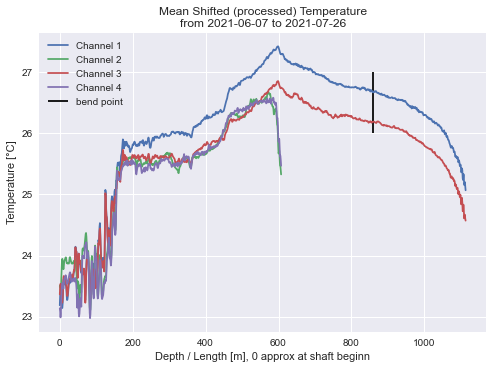

In [20]:
begin_shaft = 200
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2
print(f"bend point would be at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")

#Plot shifted data
for channel in ["1","2","3","4"]:
    y=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].mean(axis=0).values
    x=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].mean(axis=0).index - 200
    plt.plot(x,y, label=f"Channel {channel}")
plt.vlines([bend_point],26,27,color="black",label="bend point")
plt.legend()
min_date=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].index.min().strftime("%Y-%m-%d")
max_date=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")

## Interpretation
* ist knick bei depth 600 realer Temperaturänderung im Schacht? Die kurzen Kabel gehen bis ca. 600. 
    * Dieser Knick ist also bei der selben Tiefe wo das Kabel gebrochen ist. (Aus der Sicht von Channel 1 und 3 ist es auf dem Weg hoch gebrochen). 
* Ist es nicht auch verwunderlich, dass nur zwei der 4 Fasern an der Stelle gebrochen sind? Die anderen werden auch in irgendeinareweise Schaden erlitten haben?!
* Bei ca. 850 geht das Kabel irgendwann wieder hoch, ist aber nicht zu sehen, eigentlich müsste es ja symmetrisch sein ab dem Punkt wo es wieder hochgeht.
* Das der Kabelbruch Punkte von vorher beeinflusst kann eigentlich nicht sein, da das Licht ja noch gar nicht bis zum Kabelbruch gekommen ist. Beschädigungen am Kabel können also nur Punkte die später kommen beeinflussen.
* Bei ca. 0 (shaft begin) sieht man in den backscattered Daten eine Dämpfungsänderrung. Dort wurden Kabel gespleißt??????
* Bei 600 - 608 m sind bei der Kamerabefahrung Seile gefunden worden: ANh01 Fotot 18; Abschlussbericht S. 44

# Compare Channel 1-4 and Channel 5-8
Here I use the final corrected data for comparisson. The results should be "equal"

Text(0, 0.5, 'Temperature [°C]')

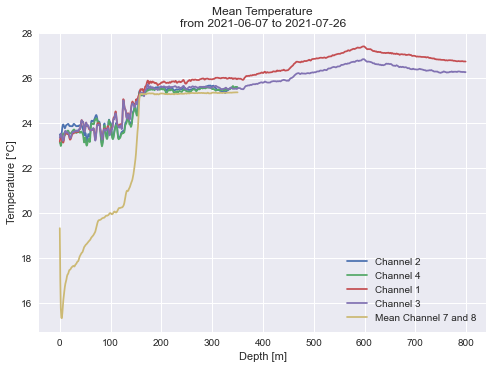

In [21]:
#both datafames have the same number of rows and dates are similar
plt.plot(shaft["2"][Schacht_7and8_down.columns].mean(axis=0).index,shaft["2"][Schacht_7and8_down.columns].mean(axis=0).values, label="Channel 2")
plt.plot(shaft["4"][Schacht_7and8_down.columns].mean(axis=0).index,shaft["4"][Schacht_7and8_down.columns].mean(axis=0).values, label="Channel 4")
plt.plot(shaft["1"].mean(axis=0).index,shaft["1"].mean(axis=0).values, label="Channel 1")
plt.plot(shaft["3"].mean(axis=0).index,shaft["3"].mean(axis=0).values, label="Channel 3")
plt.plot(Schacht_7and8_down[12:-13].mean(axis=0).index,Schacht_7and8_down[12:-13].mean(axis=0).values, label= "Mean Channel 7 and 8")
plt.legend()
min_date=shaft["2"][Schacht_7and8_down.columns].index.min().strftime("%Y-%m-%d")
max_date=shaft["2"][Schacht_7and8_down.columns].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")

In [22]:
# Calc diff to EGRT cable
channel="3"
data1 = shaft[channel][Schacht_7and8_down.columns]
data2 = Schacht_7and8_down[12:-13] #both datafames have the same number of rows and dates are similar
diff_othercable = calc_diff_between_channels(data1, data2, expected_difference_minutes=15)
diff_statistic = calc_stat_of_difference(diff_othercable["diff_abs"].transpose())

# diese Berechnung könnte ich auch für jeden Channel machen, aber man sieht ja oben, dass das keinen großen Unterschied macht

Warning 1: large time difference
0 days 00:22:02


In [23]:
#px.imshow(diff_othercable["diff"],zmin=-2,zmax=2)

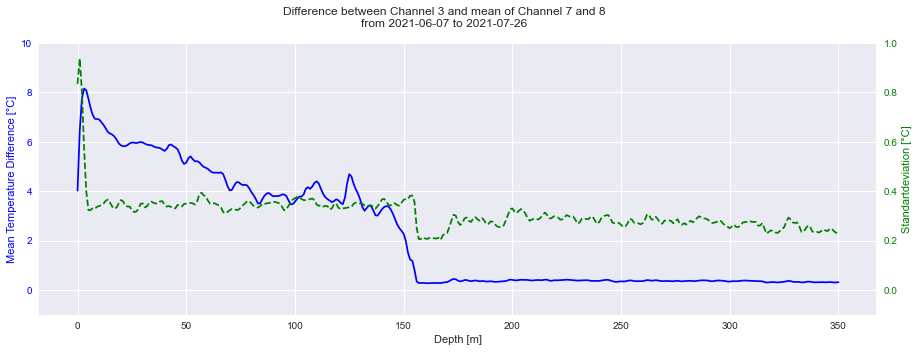

In [24]:
# Plot difference
##########Inputs##########
ymin=-1;ymax=10
cmean="blue";cstdev="green"
lstyle_mean="-";lstyle_stdev="--"
######################
fig,axs=plt.subplots(1,1,figsize=[15,5])#,constrained_layout=True)
min_date=diff_othercable["diff_abs"].columns.min().strftime("%Y-%m-%d")
max_date=diff_othercable["diff_abs"].columns.max().strftime("%Y-%m-%d")
fig.suptitle(f"Difference between Channel {channel} and mean of Channel 7 and 8\nfrom {min_date} to {max_date}")
#fig.tight_layout()

axs.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean",color=cmean,linestyle=lstyle_mean)#label="Bottom Hole Temperature"
axs.set_xlabel("Depth [m]")
axs.set_ylabel("Mean Temperature Difference [°C]",color=cmean)
axs.set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs.tick_params(axis='y', labelcolor=cmean)

axs0_2 = axs.twinx()
axs0_2.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev",color=cstdev,linestyle=lstyle_stdev) #,label="Salinity")
axs0_2.set_ylabel('Standartdeviation [°C]', color=cstdev)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cstdev)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines

### Interpretation
* Im Wasser sind sich die Ergebnisse sehr ähnlich. Vorher nicht, warum? EGRT Kabel geht durch eine Pegelleitung, wie muss ich mir das vorstellen, ist das bis zum Boden des Schachts ein seperates Rohr?
* Dadurch, dass sich diese Ergebnisse so ähnlich sind, würde ich davon ausgehen, dass mindestens dieser Bereich eine plausible Temperatur angibt.
    * Allerdings passt es ja nicht zum Wireline-log. 
        * **Entweder die Kalibration kann nicht so einfach in die Vergangenhait übertragen werden**
        * **Oder Meine gemessene Wassertank Temperatur ist falsch?** --> Also komplette Kalibration falsch?

* Die ersten 151.6 m gehen Channel 1-4 durch eine Bohrung im Beton. 
* Channel 5-8 gehen die durch ein anderes Rohr, eine Pegelleitung

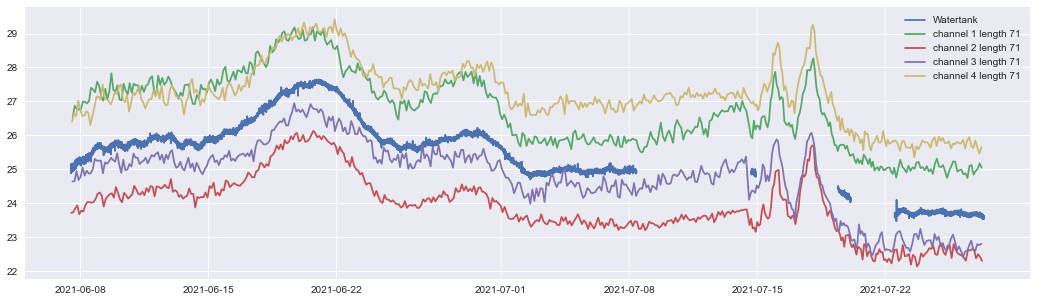

In [25]:
# Compare watertank to uncorrected channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_all[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].index
    val=data_all[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()

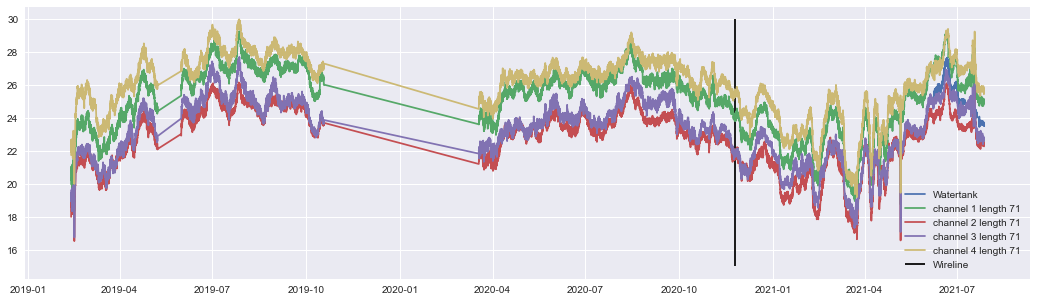

In [26]:
# Compare watertank to uncorrected channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_all[c][watertank].index
    val=data_all[c][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")
plt.vlines(pd.to_datetime("2020-11-24 12:00:00"),15,30,color="black",label="Wireline")

plt.legend()

# temperatur Stadium des Wireline logs unterscheided sich um einige Grad vom aktuellen Stadium indem es Wassertank temperaturen gibt